# Introduction
## Sales Forecasting Model
This repository contains a base sales forecasting model built in Python using the pmdarima library’s auto_arima function. The model is designed to forecast weekly sales data by capturing underlying trends and seasonal patterns inherent in the data. In this implementation, we leverage the seasonal nature of the data by specifying a seasonal period (m=52) to account for the annual cycle in weekly sales. The auto_arima function automatically identifies the best ARIMA order (p, d, q) as well as the seasonal order (P, D, Q) using information criteria.

◾️ Data Cleaning and Preprocessing
- Data Import: Raw data is imported from a CSV file.
- Date Handling: The date column is parsed as a datetime index to facilitate time series analysis.
- Numeric Conversion: Sales data (and other numeric columns) are cleaned by removing commas and converting them into integer values.

◾️ Model Building
- ARIMA Model: The auto_arima function is used to automatically determine the optimal SARIMA model parameters, with the seasonal parameter enabled and m set to 52 (reflecting the 52 weeks in a year).
- Seasonality: This allows the model to capture annual seasonal effects present in the weekly data.

◾️ Model Evaluation
- Train/Test Split: Initially, the data is split into training and testing sets to evaluate the model’s performance. Forecast accuracy is measured using metrics such as RMSE, MAE, and MAPE.
- Forecasting: After model validation, the model is retrained on the entire dataset and used to forecast future sales.

◾️ Forecasting
- Future Predictions: The model generates forecasts for specified future dates. These forecasts are then visualized alongside the historical sales data for easy comparison.
- Usage: Although the predictive accuracy of this base model may be moderate, it provides a solid framework for understanding time series forecasting with ARIMA models and serves as a foundation for further refinement and enhancement.

In [6]:
import numpy as np
import pandas as pd
import datetime
import optuna

import warnings
warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [12, 9]
plt.rcParams['font.size'] = 14

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from pmdarima.model_selection import train_test_split

# SARIMAX from statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [7]:
# =========================================================================
# 1) Read and Clean Data
# =========================================================================
dataset = "../data/sales_data.csv"
df = pd.read_csv(dataset)

# Convert 'Date' to datetime; adjust format as needed
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%y', errors='coerce')

# Clean numeric columns
df['Sales'] = pd.to_numeric(df['Sales'].str.replace(',', ''), errors='coerce').fillna(0).astype('int64')
df['Digital_Ads'] = pd.to_numeric(df['Digital_Ads'].str.replace(',', ''), errors='coerce').fillna(0).astype('int64')
df['Offline_Ads'] = pd.to_numeric(df['Offline_Ads'].astype(str).str.replace(',', ''), errors='coerce').fillna(0).astype('int64')
df['TVCM_GPR'] = pd.to_numeric(df['TVCM_GPR'].astype(str).str.replace(',', ''), errors='coerce').fillna(0)
df['Print_Media'] = pd.to_numeric(df['Print_Media'].astype(str).str.replace(',', ''), errors='coerce').fillna(0)

df.info()

# Separate into "Actual" (for train/test) and "Forecast"
df_actual = df[df['Record_Type'] == "Actual"].copy()
df_forecast = df[df['Record_Type'] == "Forecast"].copy()

# Keep only columns of interest
df_actual = df_actual[['Date', 'Sales', 'Digital_Ads', 'Offline_Ads', 'TVCM_GPR', 'Print_Media']]
df_forecast = df_forecast[['Date', 'Sales', 'Digital_Ads', 'Offline_Ads', 'TVCM_GPR', 'Print_Media']]

# Sort by Date
df_actual = df_actual.sort_values('Date')
df_forecast = df_forecast.sort_values('Date')
df_actual = df_actual.set_index('Date').sort_index()

df_forecast = df_forecast.set_index('Date').sort_index()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121 entries, 0 to 120
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         121 non-null    datetime64[ns]
 1   Sales        121 non-null    int64         
 2   TVCM_GPR     121 non-null    float64       
 3   Print_Media  121 non-null    int64         
 4   Offline_Ads  121 non-null    int64         
 5   Digital_Ads  121 non-null    int64         
 6   Record_Type  121 non-null    object        
dtypes: datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 6.7+ KB


In [3]:
df_actual.head()

,Sales,Digital_Ads,Offline_Ads,TVCM_GPR,Print_Media
Date,,,,,
2015-09-07,5554981,23080,5890000,58.86750,20340000
2015-09-14,6071669,29979,5740000,235.18125,15470000
2015-09-21,5798657,23784,0,252.18375,8325000
2015-09-28,6235157,26732,0,75.25500,0
2015-10-05,6861105,28823,0,0.00000,0


In [4]:
df_forecast.head()

,Sales,Digital_Ads,Offline_Ads,TVCM_GPR,Print_Media
Date,,,,,
2017-09-11,0,23830,5740000,235.18125,15470000
2017-09-18,0,26072,0,252.18375,8325000
2017-09-25,0,29948,0,75.25500,0
2017-10-02,0,34220,0,0.00000,0
2017-10-09,0,29145,0,44.62125,0


In [8]:
# =========================================================================
# 2) Train/Test Split on df_actual
# =========================================================================
train, test = train_test_split(df_actual, test_size=12)

print("Train shape:", train.shape)
print("Test shape :", test.shape)


# Endog and exog
exog_cols = ['Digital_Ads', 'Offline_Ads', 'TVCM_GPR', 'Print_Media']
train_endog = train['Sales']
train_exog = train[exog_cols]
test_endog = test['Sales']
test_exog = test[exog_cols]

Train shape: (93, 5)
Test shape : (12, 5)


In [9]:
def objective(trial):
    """
    Optuna の試行ごとに呼ばれる関数。試したいパラメータを trial.suggest_***() で指定。
    学習 + テストにより評価指標を返す。
    """
    
    # 2) SARIMAX のパラメータ (p,d,q)(P,D,Q,m) を探索
    p = trial.suggest_int('p', 0, 3)
    d = trial.suggest_int('d', 0, 2)
    q = trial.suggest_int('q', 0, 3)
    
    P = trial.suggest_int('P', 0, 2)
    D = trial.suggest_int('D', 0, 1)
    Q = trial.suggest_int('Q', 0, 2)
    
    # 週次データの年周期を仮定 (52)
    # 月次なら12、日次なら365(や7)などを使う
    m = 52  
    
    # モデル定義
    # enforce_stationarity, enforce_invertibility は収束しにくい場合に False 推奨
    model = SARIMAX(
        endog=train_endog,
        exog=train_exog,
        order=(p, d, q),
        seasonal_order=(P, D, Q, m),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    
    # 収束しないときにエラーが出る可能性があるので、例外処理をしておく
    try:
        results = model.fit(disp=False)
    except:
        # 収束失敗時には大きな値を返す (評価が悪かったことにする)
        return 1e10
    
    # 3) テストデータに対して予測
    forecast_obj = results.get_forecast(steps=len(test_endog), exog=test_exog)
    df_pred = forecast_obj.summary_frame()
    df_pred.rename(columns={'mean': 'yhat'}, inplace=True)
    
    # テスト実測と予測値の MAE を計算
    mae = mean_absolute_error(test_endog, df_pred['yhat'])
    
    return mae  # Optuna はこれを「最小化」するようにパラメータを探す

# ==============================================
# 4) Optuna で探索を実行
# ==============================================
study = optuna.create_study(direction='minimize')  # MAE を最小化
study.optimize(objective, n_trials=30)  # 試行回数は例として30回

# ベストパラメータを表示
print("Best params:", study.best_params)
print("Best score (MAE):", study.best_value)

# ==============================================
# 5) 最適パラメータで再学習 & テスト評価
# ==============================================
best_p = study.best_params['p']
best_d = study.best_params['d']
best_q = study.best_params['q']
best_P = study.best_params['P']
best_D = study.best_params['D']
best_Q = study.best_params['Q']
best_m = 52  # 今回は固定

best_model = SARIMAX(
    endog=train_endog,
    exog=train_exog,
    order=(best_p, best_d, best_q),
    seasonal_order=(best_P, best_D, best_Q, best_m),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

# テスト予測
forecast_obj_best = best_model.get_forecast(steps=len(test_endog), exog=test_exog)
df_pred_best = forecast_obj_best.summary_frame().rename(columns={'mean': 'yhat'})
final_mae = mean_absolute_error(test_endog, df_pred_best['yhat'])

print("Final MAE on test with best params:", final_mae)

[I 2025-03-12 19:18:40,414] A new study created in memory with name: no-name-aa006ffc-9bdc-4b9a-a6d0-a3c1b57692d5
[I 2025-03-12 19:18:42,425] Trial 0 finished with value: 1957106.9032371298 and parameters: {'p': 2, 'd': 0, 'q': 2, 'P': 0, 'D': 0, 'Q': 1}. Best is trial 0 with value: 1957106.9032371298.
[I 2025-03-12 19:18:43,491] Trial 1 finished with value: 1403224.250258045 and parameters: {'p': 0, 'd': 2, 'q': 1, 'P': 0, 'D': 0, 'Q': 2}. Best is trial 1 with value: 1403224.250258045.
[I 2025-03-12 19:18:46,152] Trial 2 finished with value: 1836013.5288218495 and parameters: {'p': 3, 'd': 2, 'q': 2, 'P': 2, 'D': 1, 'Q': 0}. Best is trial 1 with value: 1403224.250258045.
[I 2025-03-12 19:18:47,165] Trial 3 finished with value: 990945.5013017833 and parameters: {'p': 2, 'd': 2, 'q': 0, 'P': 1, 'D': 0, 'Q': 2}. Best is trial 3 with value: 990945.5013017833.
[I 2025-03-12 19:18:49,499] Trial 4 finished with value: 11109182.384994498 and parameters: {'p': 2, 'd': 2, 'q': 3, 'P': 0, 'D': 1

Best params: {'p': 0, 'd': 1, 'q': 1, 'P': 1, 'D': 0, 'Q': 0}
Best score (MAE): 426084.89254179597
Final MAE on test with best params: 426084.89254179597


In [10]:
# # =========================================================================
# # 3) SARIMAX Model with Exogenous Regressors
# # =========================================================================
# # Example order; you can tune these
# order = (1, 1, 1)
# seasonal_order = (1, 1, 1, 52)  # weekly data with yearly seasonality

# print("\n--- Fitting SARIMAX model ---")
# model = SARIMAX(
#     endog=train_endog,
#     exog=train_exog,
#     order=order,
#     seasonal_order=seasonal_order,
#     enforce_stationarity=False,
#     enforce_invertibility=False
# )
# results = model.fit(disp=False)
# print(results.summary())

best_p = study.best_params['p']
best_d = study.best_params['d']
best_q = study.best_params['q']
best_P = study.best_params['P']
best_D = study.best_params['D']
best_Q = study.best_params['Q']
best_m = 52  # 今回は週次の年周期

# ここで最終的に学習
model = SARIMAX(
    endog=train_endog,
    exog=train_exog,
    order=(best_p, best_d, best_q),
    seasonal_order=(best_P, best_D, best_Q, best_m),
    enforce_stationarity=False,
    enforce_invertibility=False
)
results = model.fit(disp=False)
print(results.summary())


                                      SARIMAX Results                                      
Dep. Variable:                               Sales   No. Observations:                   93
Model:             SARIMAX(0, 1, 1)x(1, 0, [], 52)   Log Likelihood                -591.756
Date:                             Wed, 12 Mar 2025   AIC                           1197.513
Time:                                     19:20:31   BIC                           1209.335
Sample:                                 09-07-2015   HQIC                          1201.788
                                      - 06-12-2017                                         
Covariance Type:                               opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Digital_Ads    35.0201     18.664      1.876      0.061      -1.561      71.601
Offline_Ads    -0.0187  

In [11]:
###############################################################################
# 5) テスト期間に対する予測を取得 → 評価指標を計算
###############################################################################
# ステップ数はテストデータの長さ
steps = len(test_endog)

# 予測オブジェクトを作成
forecast_obj_test = results.get_forecast(steps=steps, exog=test_exog)

# 予測値と信頼区間を含む DataFrame
df_test_forecast = forecast_obj_test.summary_frame()

# 列のリネーム (mean → yhat, など)
df_test_forecast.rename(columns={
    'mean': 'yhat',
    'mean_ci_lower': 'yhat_lower',
    'mean_ci_upper': 'yhat_upper'
}, inplace=True)

# テスト時系列に合わせてインデックスを揃える (get_forecastは自動的に連続した期間で生成するはずだが念のため)
df_test_forecast.index = test_endog.index

# 実測値(Sales) を結合 → 比較しやすくする
df_test_forecast['Sales'] = test_endog

# 評価指標(RMSE, MAE, MAPEなど)を計算
rmse = np.sqrt(mean_squared_error(df_test_forecast['Sales'], df_test_forecast['yhat']))
mae  = mean_absolute_error(df_test_forecast['Sales'], df_test_forecast['yhat'])
mape = mean_absolute_percentage_error(df_test_forecast['Sales'], df_test_forecast['yhat'])

print("\n==== Test Evaluation ====")
print("RMSE:", rmse)
print("MAE: ", mae)
print("MAPE:", mape)


==== Test Evaluation ====
RMSE: 625020.5423995965
MAE:  426084.89254179597
MAPE: 0.060710581690177214


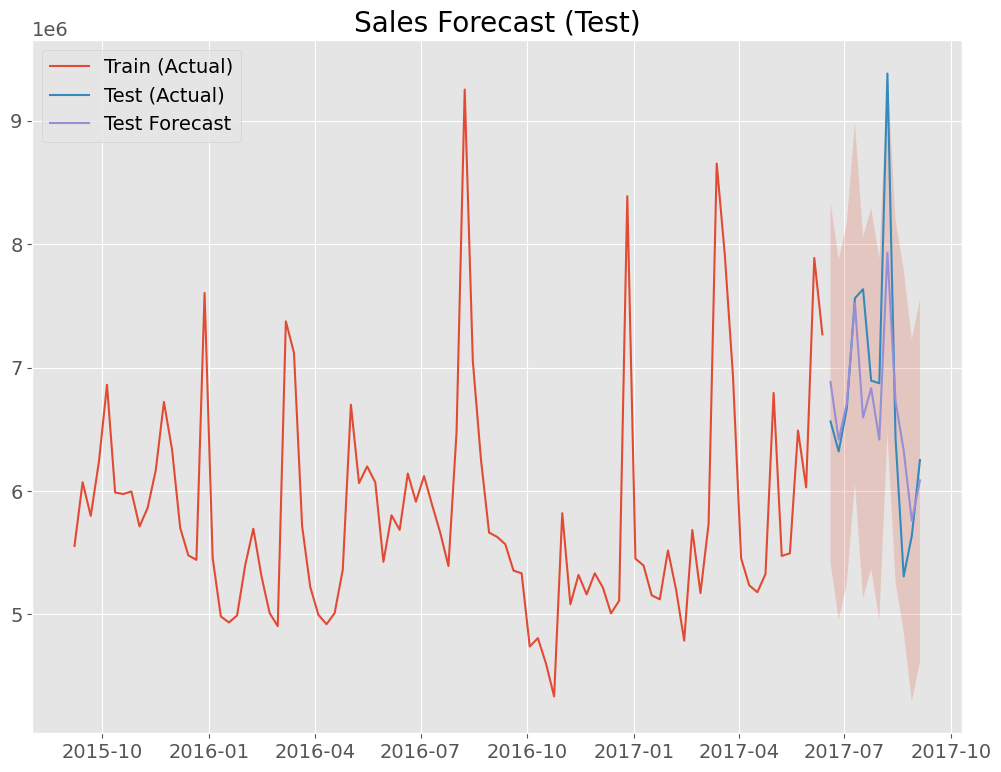

In [13]:
###############################################################################
# 6) 予測値（テスト期間）を可視化
###############################################################################
plt.figure()
plt.plot(train.index, train['Sales'], label='Train (Actual)')
plt.plot(test.index, test['Sales'], label='Test (Actual)')

# テスト期間の予測値
plt.plot(df_test_forecast.index, df_test_forecast['yhat'], label='Test Forecast')

# 信頼区間を塗りつぶしで表示 (薄い色で)
plt.fill_between(df_test_forecast.index,
                 df_test_forecast['yhat_lower'],
                 df_test_forecast['yhat_upper'],
                 alpha=0.2)

plt.title('Sales Forecast (Test)')
plt.legend()
plt.show()

In [18]:
df_forecast = df_forecast.copy()
df_forecast.index = pd.to_datetime(df_forecast.index)  # もしインデックスがstr型の場合
df_forecast = df_forecast.sort_index() 

In [19]:
# 外因変数の列名リスト（学習時に使ったものと同じにする）
exog_cols = ['Digital_Ads', 'Offline_Ads', 'TVCM_GPR', 'Print_Media']

# 将来予測を行う
steps_forecast = len(df_forecast)  # df_forecast の行数分だけ予測
future_exog = df_forecast[exog_cols]

future_forecast_obj = results.get_forecast(
    steps=steps_forecast,
    exog=future_exog
)

# 予測値・信頼区間入りのDataFrameを取得
df_future_forecast = future_forecast_obj.summary_frame()

# 列のリネーム
df_future_forecast.rename(columns={
    'mean': 'yhat',
    'mean_ci_lower': 'yhat_lower',
    'mean_ci_upper': 'yhat_upper'
}, inplace=True)

# インデックスを df_forecast と揃える (get_forecast() が返すindexと一致しているか確認)
df_future_forecast.index = df_forecast.index  

In [20]:
# df_forecast['Sales'] = yhat列 を代入
df_forecast['Sales'] = df_future_forecast['yhat'].values
df_forecast['yhat_lower'] = df_future_forecast['yhat_lower'].values
df_forecast['yhat_upper'] = df_future_forecast['yhat_upper'].values

In [21]:
df_forecast

,Sales,Digital_Ads,Offline_Ads,TVCM_GPR,Print_Media,yhat_lower,yhat_upper
Date,,,,,,,
2017-09-11,5.234784e+06,23830,5740000,235.18125,15470000,3.774593e+06,6.694976e+06
2017-09-18,5.313358e+06,26072,0,252.18375,8325000,3.852451e+06,6.774266e+06
2017-09-25,5.380141e+06,29948,0,75.25500,0,3.918518e+06,6.841764e+06
2017-10-02,5.542700e+06,34220,0,0.00000,0,4.080362e+06,7.005039e+06
2017-10-09,5.231133e+06,29145,0,44.62125,0,3.768079e+06,6.694186e+06
2017-10-16,5.125106e+06,25991,0,50.16750,0,3.661338e+06,6.588874e+06
2017-10-23,4.911969e+06,18571,8360000,46.60875,0,3.447486e+06,6.376451e+06
2017-10-30,6.199278e+06,32704,8710000,115.46625,15900000,4.734081e+06,7.664474e+06
2017-11-06,5.585585e+06,29000,9050000,185.66250,7835000,4.119675e+06,7.051496e+06


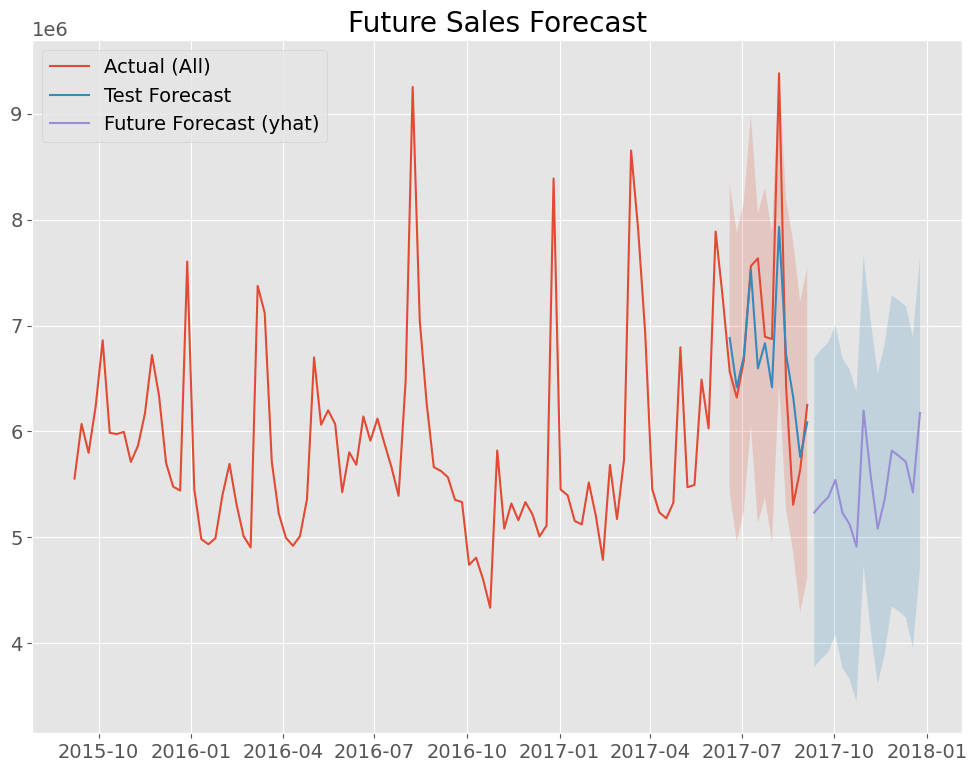

In [22]:
import matplotlib.pyplot as plt

plt.figure()

# 学習 + テスト実測 (dfがあるなら)
plt.plot(df_actual.index, df_actual['Sales'], label='Actual (All)')

# テスト予測 (df_test_forecast) があれば
plt.plot(df_test_forecast.index, df_test_forecast['yhat'], label='Test Forecast')
plt.fill_between(df_test_forecast.index,
                 df_test_forecast['yhat_lower'],
                 df_test_forecast['yhat_upper'],
                 alpha=0.2)

# 今回の future forecast を重ねる
plt.plot(df_forecast.index, df_forecast['Sales'], label='Future Forecast (yhat)')

# 信頼区間も描画する場合
if 'yhat_lower' in df_forecast.columns:
    plt.fill_between(df_forecast.index,
                     df_forecast['yhat_lower'],
                     df_forecast['yhat_upper'],
                     alpha=0.2)

plt.title('Future Sales Forecast')
plt.legend()
plt.show()

# Conclusion

The forecasting horizon was very short, which limited the model's ability to fully capture the underlying seasonal patterns and trends. As a result, the predictions were not as accurate as expected. In future work, extending the historical data and increasing the forecasting period may improve the model's performance and provide more reliable forecasts.